In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [2]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8791 entries, 0 to 8790
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    8791 non-null   int64  
 1   V1      8791 non-null   float64
 2   V2      8791 non-null   float64
 3   V3      8791 non-null   float64
 4   V4      8791 non-null   float64
 5   V5      8791 non-null   float64
 6   V6      8791 non-null   float64
 7   V7      8791 non-null   float64
 8   V8      8791 non-null   float64
 9   V9      8791 non-null   float64
 10  V10     8791 non-null   float64
 11  V11     8791 non-null   float64
 12  V12     8791 non-null   float64
 13  V13     8791 non-null   float64
 14  V14     8790 non-null   float64
 15  V15     8790 non-null   float64
 16  V16     8790 non-null   float64
 17  V17     8790 non-null   float64
 18  V18     8790 non-null   float64
 19  V19     8790 non-null   float64
 20  V20     8790 non-null   float64
 21  V21     8790 non-null   float64
 22  

## Exploratory Data Analysis

In [4]:
data.isnull().values.any()

True

Text(0, 0.5, 'Frequency')

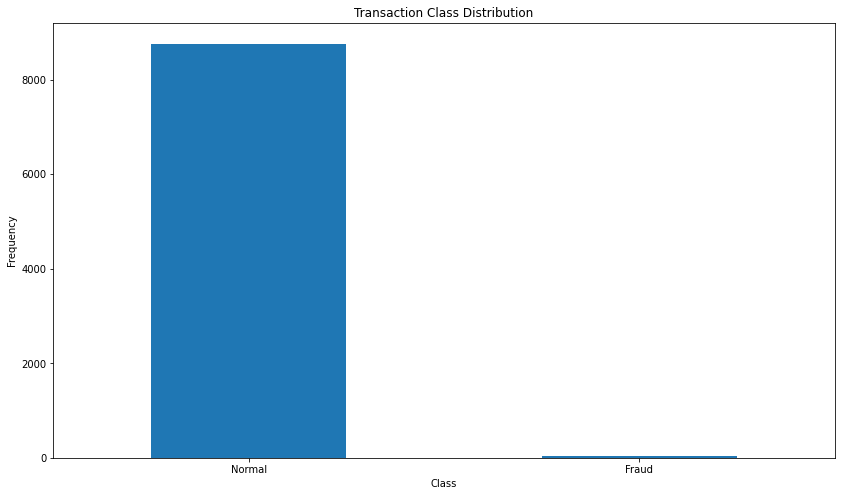

In [5]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [6]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]
normal = data[data['Class']==0]

In [7]:
print(fraud.shape,normal.shape)

(30, 31) (8760, 31)


In [8]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count      30.000000
mean       88.757000
std       341.372542
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1809.680000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    8760.000000
mean       63.678126
std       189.095768
min         0.000000
25%         5.000000
50%        15.950000
75%        52.502500
max      7712.430000
Name: Amount, dtype: float64

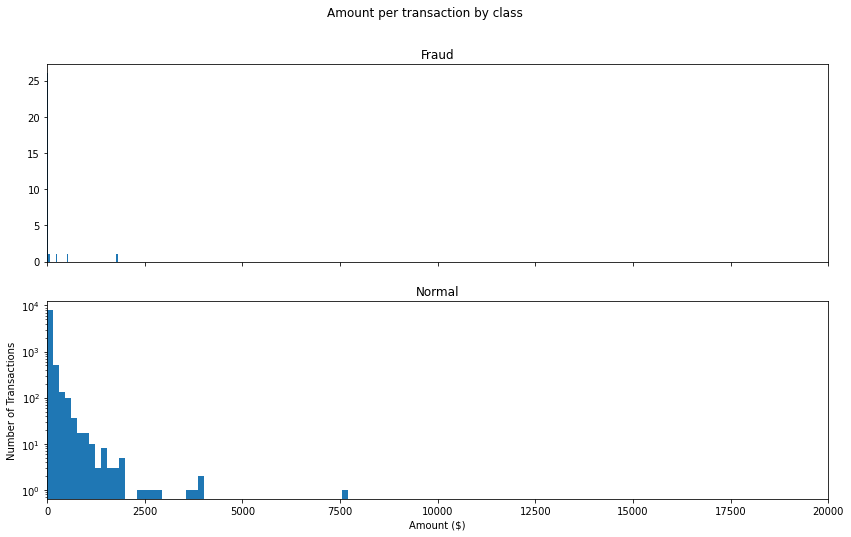

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

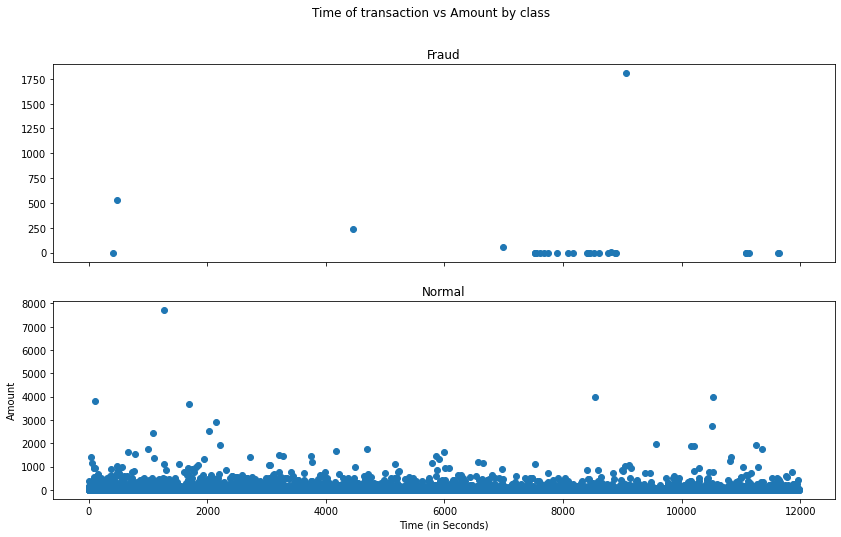

In [14]:
# Выявояем аномальные временные промежутки

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [15]:
data1= data.sample(frac = 0.1,random_state=1)
data1.shape

(879, 31)

In [16]:
data.shape

(8791, 31)

In [17]:
#Опрееляем отношение мошеннических операций к обычным

Fraud = data1[data1['Class']==1]
Valid = data1[data1['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [18]:
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

0.002280501710376283
Fraud Cases : 2
Valid Cases : 877


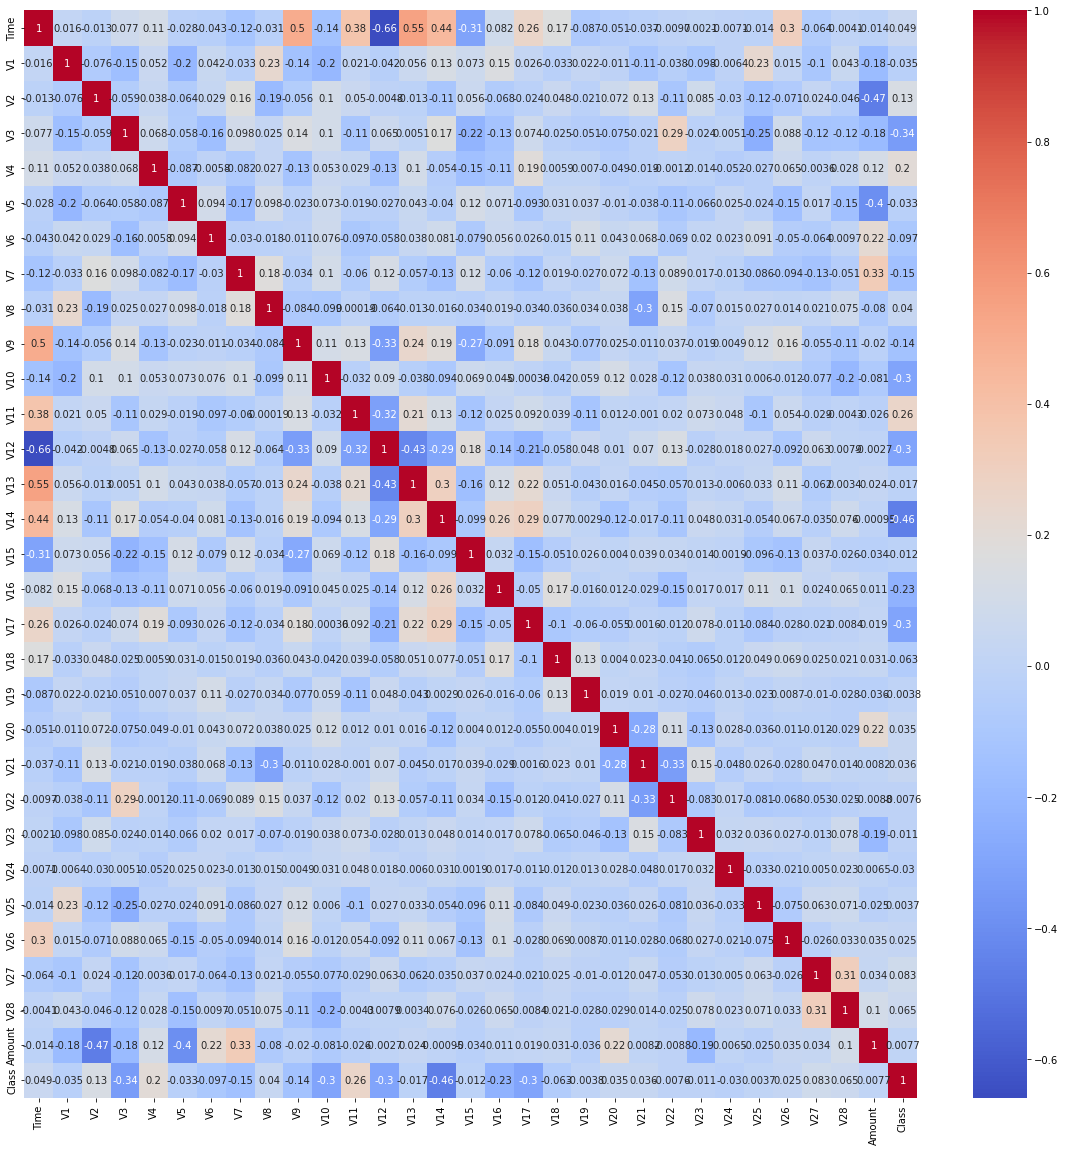

In [20]:
#Кореляционный анализ
import seaborn as sns
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap='coolwarm')

In [21]:
columns = data1.columns.tolist()
# Отфильтровать столбцы, чтобы удалить данные, которые нам не нужны
columns = [c for c in columns if c not in ["Class"]]
target = "Class"
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(879, 30)
(879,)




### Isolation Forest Algorithm :
Один из новейших методов обнаружения аномалий называется изолированными лесами. Алгоритм основан на том факте, что аномалии — это несколько разных точек данных. В результате этих свойств аномалии подвержены механизму, называемому изоляцией.

Этот метод очень полезен и принципиально отличается от всех существующих методов. Он вводит использование изоляции как более эффективного и действенного средства обнаружения аномалий, чем обычно используемые базовые меры расстояния и плотности. Кроме того, этот метод представляет собой алгоритм с низкой линейной временной сложностью и небольшими требованиями к памяти. Он строит хорошо работающую модель с небольшим количеством деревьев, используя небольшие подвыборки фиксированного размера, независимо от размера набора данных.

Типичные методы машинного обучения, как правило, работают лучше, когда шаблоны, которые они пытаются изучить, сбалансированы, что означает, что в наборе данных присутствует одинаковое количество хороших и плохих поведений.

Как работают изолирующие леса Алгоритм изолированного леса изолирует наблюдения, случайным образом выбирая признак, а затем случайным образом выбирая значение разделения между максимальным и минимальным значениями выбранного признака. Логический аргумент таков: изолировать наблюдения аномалий легче, потому что требуется всего несколько условий, чтобы отделить эти случаи от нормальных наблюдений. С другой стороны, выделение нормальных наблюдений требует большего количества условий. Следовательно, показатель аномалии можно рассчитать как количество условий, необходимых для разделения данного наблюдения.

Способ, которым алгоритм строит разделение, заключается в том, что сначала создаются деревья изоляции или деревья случайных решений. Затем оценка рассчитывается как длина пути, чтобы изолировать наблюдение.


### Local Outlier Factor(LOF) Algorithm
Алгоритм LOF — это неконтролируемый метод обнаружения выбросов, который вычисляет отклонение локальной плотности заданной точки данных по отношению к ее соседям. Выбросами считаются образцы, имеющие значительно меньшую плотность, чем их соседи.

Количество рассматриваемых соседей (параметр n_neighbors) обычно выбирается 1) больше, чем минимальное количество объектов, которое должен содержать кластер, чтобы другие объекты могли быть локальными выбросами по отношению к этому кластеру, и 2) меньше, чем максимальное количество объектов. рядом с объектами, которые потенциально могут быть локальными выбросами. На практике такая информация, как правило, недоступна, и выбор n_neighbors=20 в целом работает хорошо.

In [27]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
}

In [28]:
type(classifiers)

dict

In [30]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Меняем значения прогноза на 0 для нормальных транзакций, 1 для мошеннических транзакций.
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Запустить метрики классификации
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 3
Accuracy Score :
0.9965870307167235
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       877
         1.0       0.33      0.50      0.40         2

    accuracy                           1.00       879
   macro avg       0.67      0.75      0.70       879
weighted avg       1.00      1.00      1.00       879

Local Outlier Factor: 5
Accuracy Score :
0.9943117178612059
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       877
         1.0       0.00      0.00      0.00         2

    accuracy                           0.99       879
   macro avg       0.50      0.50      0.50       879
weighted avg       1.00      0.99      0.99       879



#### Заключение:
Используя Isolation Forest и Local Outlier Factor для обнаружения аномалий в данных, было обнаружено, что Isolation Forest нашел меньше ошибок (73) по сравнению с LOF (97) и имел более высокую точность (99,74% против 99,65%). Точность и полнота ошибок также были лучше у Isolation Forest, который смог обнаружить около 27% случаев мошенничества, в то время как LOF смог обнаружить только 2%. Это говорит о том, что Isolation Forest является более эффективным методом для обнаружения мошеннических случаев. Однако, чтобы улучшить точность, можно увеличить размер выборки или использовать алгоритмы глубокого обучения, хотя это может привести к вычислительным затратам. Также возможно использование более сложных моделей обнаружения аномалий для повышения точности выявления мошеннических случаев.